In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
# warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import folium
import seaborn as sns

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
import split_images
reload(split_images)
from split_images import split_geometry, haversine, calc_segment_count

In [3]:
from analysis_image import AnalysisImage
from keras.preprocessing import image

In [4]:
ee.Authenticate()
ee.Initialize()

In [5]:
'''
We begin by preparing some constant variables that will be used throughout the notebook. 
Note that a seed is set for reproducibility.
'''

SEED = 2024
keras.utils.set_random_seed(SEED)
# FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
FEATURES = ['B2', 'B3', 'B4']

In [6]:
import analysis_image
reload(analysis_image)
from analysis_image import AnalysisImage

In [7]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2023, feature_bands=FEATURES)

In [8]:
img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 600, 600)

In [9]:
folder_path = os.path.join('image_clips', 'tegucigalpa', '2023')
files = tegucigalpa_image.extract_clips_to_folder(folder_path, 'tegucigalpa', x_num_parts, y_num_parts)

Found existing image_clips\tegucigalpa\2023\tegucigalpa.tif files. Use that instead <3.


In [10]:
from tensorflow.keras.applications import EfficientNetB7 as effnet
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_p

In [30]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [31]:
tegu_600_eloisa = Eloisa(name="tegu_600x600", db_folder="eloisa_databases", seed=SEED, image_shape=(600, 600, 3))

The database already exists. Connecting to it.


100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


In [32]:
tegu_600_eloisa.get_data()

defaultdict(dict,
            {2023: {'image_list': [<PIL.Image.Image image mode=RGB size=600x600>,
               <PIL.Image.Image image mode=RGB size=600x600>,
               <PIL.Image.Image image mode=RGB size=600x600>],
              'EfficientNetB7':        0         1         2         3         4         5         6     \
              0 -0.156504  0.010746  0.011965 -0.052384 -0.202820  0.171316  0.055353   
              1  0.211039 -0.146875 -0.185208  0.172146 -0.144934 -0.066054  0.025003   
              2  0.135755 -0.111907 -0.225176  0.185762 -0.155101 -0.128389  0.026886   
              
                     7         8         9     ...      2550      2551      2552      2553  \
              0  0.049675  0.437704 -0.139547  ... -0.092307  0.020802 -0.072811  0.003190   
              1 -0.059879 -0.089694 -0.152837  ... -0.107619 -0.157131 -0.194431  0.036358   
              2  0.149550  0.073822 -0.161162  ... -0.005319 -0.162339 -0.131650  0.194485   
          

In [13]:
tegu_600_eloisa.import_images_by_year(folder_path=folder_path, year=2023, bands=[1, 2, 3])

100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


In [14]:
tegu_600_eloisa.extract_features(year=2023, model=effnet, preprocess_input=effnet_p)

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


In [15]:
tegu_600_eloisa.update_database()

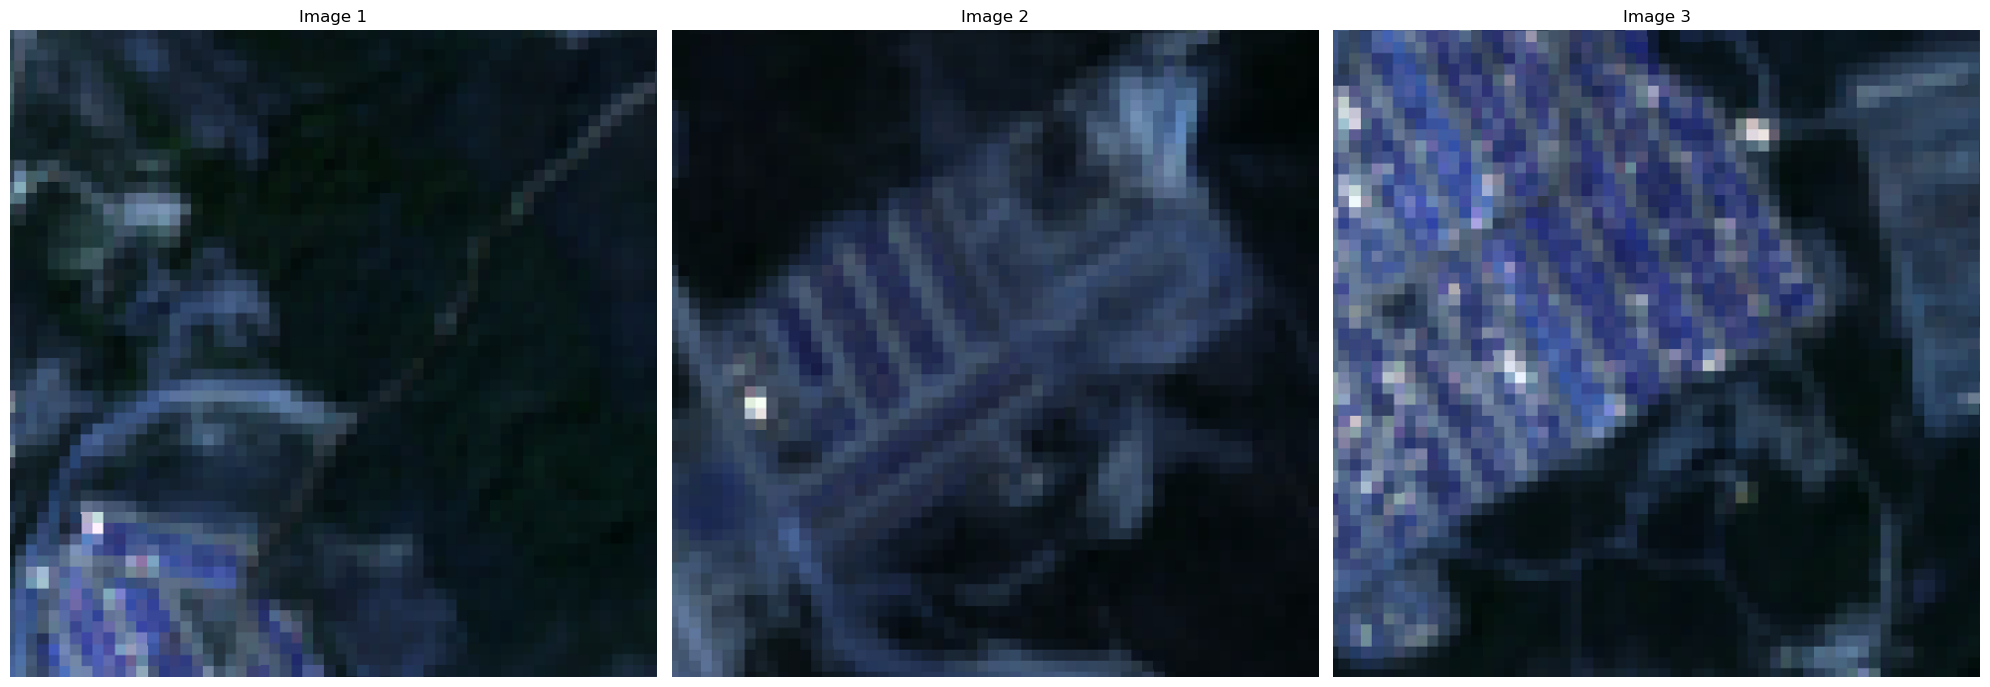

In [33]:
tegu_600_eloisa.show_images_sample(year=2023, rows=1, cols=3)

In [16]:
tegu_600_eloisa.scale_features(year=2023, model=effnet)

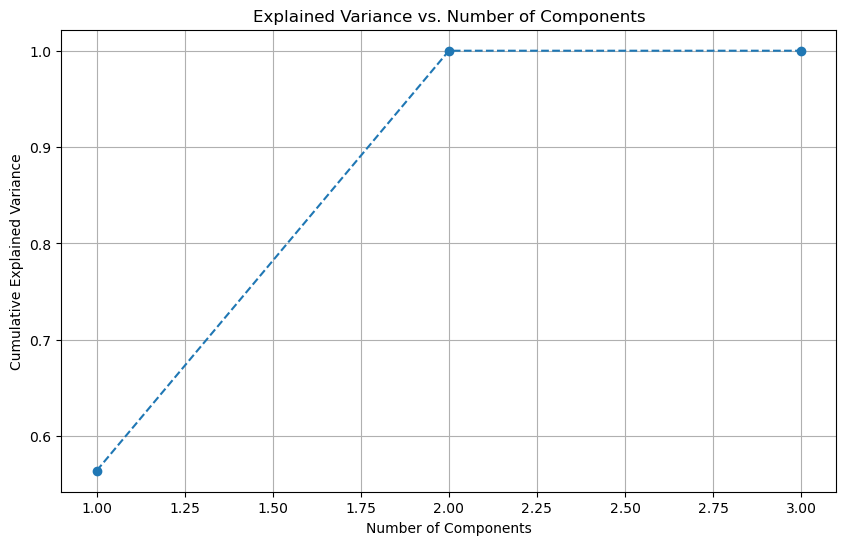

Number of components to retain 95.0% variance: 2


In [17]:
tegu_600_eloisa.pca_features(year=2023, model=effnet, variance_min=0.95, plot_variance=True)

In [354]:
tegu_600_eloisa.calc_silhouette_score(year=2023, model=effnet, kmax=100, show_plot=True)

ValueError: Number of labels is 3. Valid values are 2 to n_samples - 1 (inclusive)

In [355]:
tegu_600_eloisa.plot_elbow_curve(year=2023, model=effnet, kmax=100)

ValueError: n_samples=3 should be >= n_clusters=4.

In [18]:
tegu_600_eloisa.calc_kmeans_clusters(year=2023, model=effnet, n_clusters=2)

c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\juane\miniforge3\envs\TemporalClusterNet\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [19]:
tegu_600_eloisa.update_database()

In [21]:
tegu_600_eloisa.close_db()

# Delete database using os.remove() method
# os.remove(tegu_600_eloisa.db_path)